# Autoregressive Model Testing (SARIMA & SARIMAX)

Next Step: tune P, D, Q after r, 
Optimize crypto lag

In [1974]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import itertools
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, HTML
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey
from statsmodels.api import OLS, add_constant
from scipy.stats import shapiro, anderson
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from scipy import stats 
from statsmodels.stats.stattools import durbin_watson

In [1975]:
# Load data
df = pd.read_excel('data/trimmed_Monthly Mastersheet Original Data.xlsx')

# Ensure date is datetime and set index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='MS')
df.columns = df.columns.str.strip()

## Data Preparation

In [ ]:
macro_list = ['LFPR', 'CPI', 'r', 'M1', 'GDP', 'IM', 'EX', 'CC']
asset_list= ['Bitcoin', 'Tether', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano', 'USD Coin']
nonstable_list = ['Bitcoin', 'Litecoin', 'XRP', 'Ethereum', 'Dogecoin', 'Cardano']
stable_list = ['Tether', 'USD Coin']
train_start = '2020-06-01'
train_end = '2024-01-01'

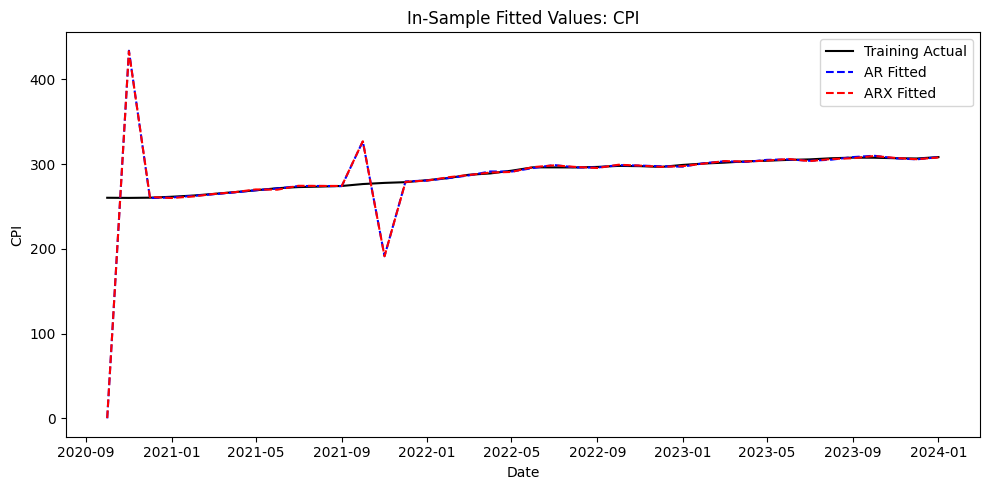

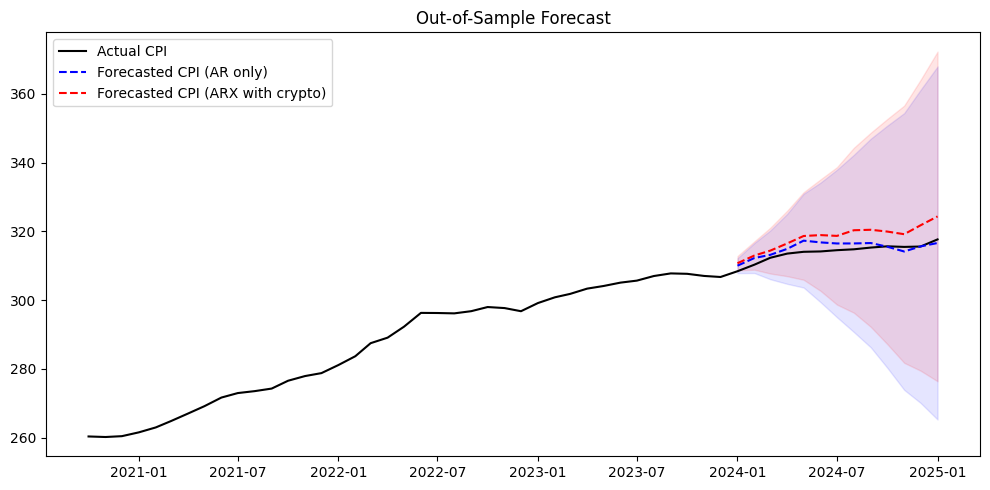

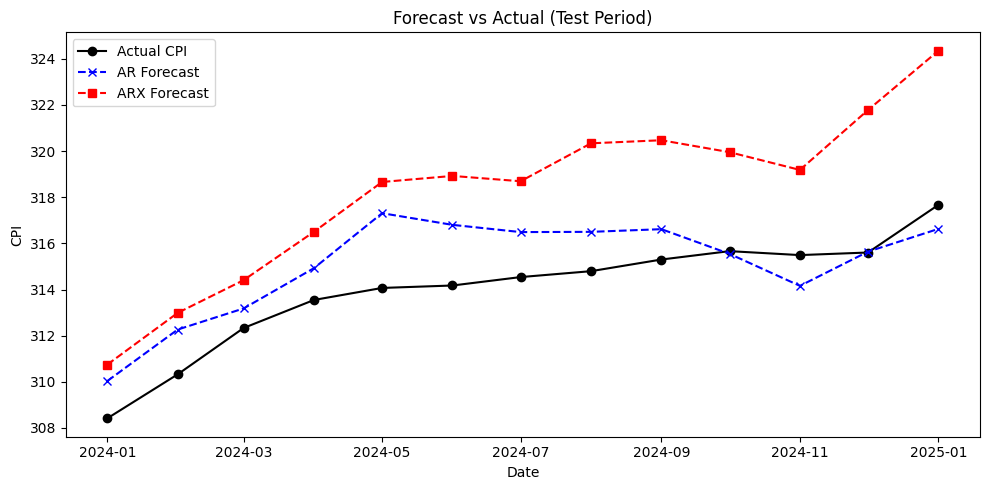

(            MAE      RMSE        R2  MAPE (%)    Order
 Model                                                 
 AR     1.473298  1.703465  0.471350  0.469800  (1,2,0)
 ARX    4.236219  4.461220 -2.625845  1.346523  (1,2,0),
 {'Breusch-Pagan p': np.float64(0.20963384353275),
  'Shapiro p': np.float64(0.9745533691584115),
  'Anderson stat': np.float64(0.11798998086942447),
  'Anderson crit': [(np.float64(15.0), np.float64(0.516)),
   (np.float64(10.0), np.float64(0.587)),
   (np.float64(5.0), np.float64(0.705)),
   (np.float64(2.5), np.float64(0.822)),
   (np.float64(1.0), np.float64(0.978))],
  'Mean resid': np.float64(-0.10789751808198826),
  'Durbin-Watson': np.float64(2.2095518253206468)})

In [1977]:
run_model(df.copy(), 'CPI', nonstable_list, plot = True)

In [1978]:
ar_orders = {}
ar_orders['LFPR'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 
                     'Bitcoin_lag': 1, 'Tether_lag': 3, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                     'Cardano_lag': 2, 'USD Coin_lag': 0, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 1}
ar_orders['CPI'] = {'p': 1, 'd': 2, 'q': 0, 'P': 1, 'D': 1, 'Q': 0, 
                    'Bitcoin_lag': 3, 'Tether_lag': 5, 'Litecoin_lag': 4, 'XRP_lag': 5, 'Ethereum_lag': 0, 'Dogecoin_lag': 6, 
                    'Cardano_lag': 2, 'USD Coin_lag': 2, 'PC1_crypto_lag': 6, 'PC2_crypto_lag': 2}
ar_orders['r'] = {'p': 1, 'd': 2, 'q': 0, 'P': 0, 'D': 1, 'Q': 0, 
                  'Bitcoin_lag': 6, 'Tether_lag': 5, 'Litecoin_lag': 5, 'XRP_lag': 3, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                  'Cardano_lag': 2, 'USD Coin_lag': 2, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 0}
ar_orders['M1'] = {'p': 1, 'd': 3, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 
                   'Bitcoin_lag': 1, 'Tether_lag': 2, 'Litecoin_lag': 2, 'XRP_lag': 5, 'Ethereum_lag': 2, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 0, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1}
ar_orders['GDP'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 
                            'Bitcoin_lag': 0, 'Tether_lag': 2, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 4, 'Dogecoin_lag': 1, 
                            'Cardano_lag': 0, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0}
ar_orders['IM'] = {'p': 2, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 2, 
                   'Bitcoin_lag': 0, 'Tether_lag': 1, 'Litecoin_lag': 2, 'XRP_lag': 3, 'Ethereum_lag': 3, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 3, 'USD Coin_lag': 1, 'PC1_crypto_lag': 2, 'PC2_crypto_lag': 0}
ar_orders['EX'] = {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 0, 
                   'Bitcoin_lag': 4, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 0, 
                   'Cardano_lag': 0, 'USD Coin_lag': 6, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 0}
ar_orders['CC'] = {'p': 1, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 
                   'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 4, 'Ethereum_lag': 0, 'Dogecoin_lag': 3, 
                   'Cardano_lag': 0, 'USD Coin_lag': 4, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0}
ar_orders['PC1_macro'] = {'p': 1, 'd': 3, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 
                          'Bitcoin_lag': 2, 'Tether_lag': 0, 'Litecoin_lag': 2, 'XRP_lag': 4, 'Ethereum_lag': 1, 'Dogecoin_lag': 4, 
                          'Cardano_lag': 1, 'USD Coin_lag': 4, 'PC1_crypto_lag': 1, 'PC2_crypto_lag': 1, 'VIX_lag': 0}
ar_orders['PC2_macro'] = {'p': 1, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 2, 
                          'Bitcoin_lag': 0, 'Tether_lag': 0, 'Litecoin_lag': 0, 'XRP_lag': 0, 'Ethereum_lag': 0, 'Dogecoin_lag': 1, 
                          'Cardano_lag': 1, 'USD Coin_lag': 2, 'PC1_crypto_lag': 0, 'PC2_crypto_lag': 0, 'VIX_lag': 0}

# ar_orders['CC 
# 
#  % Change'] = {'p': 2, 'd': 0,'q': 0, 'P': 2, 'D': 1, 'Q': 0}
# ar_orders['VIX'] = {'p': 1, 'd': 0,'q': 0, 'P': 1, 'D': 1, 'Q': 0}
# ar_orders['MOVE'] = {'p': 1, 'd': 1,'q': 0, 'P': 1, 'D': 0, 'Q': 0}
# ar_orders['vol_LFPR'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_CPI'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_r'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_M1'] = {'p': 1, 'd': 1,'q': 0}
# ar_orders['vol_GDP'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_IM'] = {'p': 1, 'd': 2,'q': 0}
# ar_orders['vol_EX'] = {'p': 1, 'd': 1, 'q': 0}
# ar_orders['vol_CC'] = {'p': 1, 'd': 1,'q': 0}

## Checking Variable Stationarity, ACF, PACF

In [1979]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f"ADF test for {series.name}: p-value = {p_value:.4f}")

In [1980]:
# ACF and PACF
def acf(series, name = 'variable'):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(series, lags=30, ax=ax[0])
    ax[0].set_title(f'ACF of {name}')
    plot_pacf(series, lags=20, ax=ax[1])
    ax[1].set_title(f'PACF of {name}')
    plt.tight_layout()
    plt.show()

In [1981]:
# variable = 'PC2_macro'
# check_stationarity(df[variable])
# series = df[variable].dropna()
# acf(series, variable)
# df[f'{variable}_diff'] = df[variable].diff()
# series = df[f'{variable}_diff'].dropna()
# acf(series, f'{variable}_diff')
# check_stationarity(df[f'{variable}_diff'])

# df[f'{variable}_diff_diff'] = df[f'{variable}_diff'].diff()
# series = df[f'{variable}_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff'])

# df[f'{variable}_diff_diff_diff'] = df[f'{variable}_diff_diff'].diff()
# series = df[f'{variable}_diff_diff_diff'].dropna()
# acf(series, f'{variable}_diff_diff_diff')
# check_stationarity(df[f'{variable}_diff_diff_diff'])

## SARIMA(X) Model

In [1982]:
from itertools import product
P = Q = range(0, 3)
D = [0, 1]
s = 12  # for monthly data

# All combinations of parameters

seasonal_combinations = list(product(P, D, Q))

In [1983]:
def find_best_seasonal_order(y, macro, ar_orders, exog=None, seasonal_period=12, verbose=False):
    best_aic = np.inf
    best_model = None
    best_seasonal_order = None

    # Fixed p, d, q
    order = (
        ar_orders[macro]['p'],
        ar_orders[macro]['d'],
        ar_orders[macro]['q']
    )

    for P, D, Q in seasonal_combinations:
        seasonal_order = (P, D, Q, seasonal_period)

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = SARIMAX(
                    y,
                    exog=exog,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_model = results
                    best_seasonal_order = seasonal_order

                if verbose:
                    print(f"Tried SARIMA{order}x{seasonal_order} AIC={results.aic:.2f}")

        except Exception as e:
            if verbose:
                print(f"Failed SARIMA{order}x{seasonal_order}: {e}")
            continue

    return order, best_seasonal_order, best_model

In [1984]:
macro = "PC2_macro"
y = df[macro].dropna()

order, best_seasonal_order, best_model = find_best_seasonal_order(y, macro, ar_orders, seasonal_period=12, verbose=True)

print("Fixed order:", order)
print("Best seasonal order:", best_seasonal_order)
print("Best AIC:", best_model.aic)

Tried SARIMA(1, 1, 0)x(0, 0, 0, 12) AIC=688.73
Tried SARIMA(1, 1, 0)x(0, 0, 1, 12) AIC=520.66
Tried SARIMA(1, 1, 0)x(0, 0, 2, 12) AIC=371.76
Tried SARIMA(1, 1, 0)x(0, 1, 0, 12) AIC=544.92
Tried SARIMA(1, 1, 0)x(0, 1, 1, 12) AIC=849.47
Tried SARIMA(1, 1, 0)x(0, 1, 2, 12) AIC=224.77
Tried SARIMA(1, 1, 0)x(1, 0, 0, 12) AIC=517.12
Tried SARIMA(1, 1, 0)x(1, 0, 1, 12) AIC=518.10
Tried SARIMA(1, 1, 0)x(1, 0, 2, 12) AIC=372.24
Tried SARIMA(1, 1, 0)x(1, 1, 0, 12) AIC=372.06
Tried SARIMA(1, 1, 0)x(1, 1, 1, 12) AIC=1241.21
Tried SARIMA(1, 1, 0)x(1, 1, 2, 12) AIC=226.52
Tried SARIMA(1, 1, 0)x(2, 0, 0, 12) AIC=364.04
Tried SARIMA(1, 1, 0)x(2, 0, 1, 12) AIC=365.34
Tried SARIMA(1, 1, 0)x(2, 0, 2, 12) AIC=364.44
Tried SARIMA(1, 1, 0)x(2, 1, 0, 12) AIC=226.69
Tried SARIMA(1, 1, 0)x(2, 1, 1, 12) AIC=228.67
Tried SARIMA(1, 1, 0)x(2, 1, 2, 12) AIC=227.80
Fixed order: (1, 1, 0)
Best seasonal order: (0, 1, 2, 12)
Best AIC: 224.77140455223832


In [1985]:
def check_model_assumptions(y_train, X_train, model_residuals):
    # Add constant to X
    X_const = add_constant(X_train)
    
    # 1. Breusch–Pagan test for heteroskedasticity
    ols_model = OLS(y_train, X_const).fit()
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_const)

    # 2. Shapiro-Wilk test for normality
    shapiro_stat, shapiro_p = shapiro(model_residuals)

    # 3. Anderson-Darling test
    ad_result = anderson(model_residuals)
    ad_stat = ad_result.statistic
    ad_crit = list(zip(ad_result.significance_level, ad_result.critical_values))

    # 6. Mean of residuals
    mean_resid = model_residuals.mean()

    # 7. Durbin-Watson test for autocorrelation
    dw_stat = durbin_watson(model_residuals)

    
    return {
        "Breusch-Pagan p": bp_pvalue,
        "Shapiro p": shapiro_p,
        "Anderson stat": ad_stat,
        "Anderson crit": ad_crit,
        "Mean resid": mean_resid,
        "Durbin-Watson": durbin_watson(model_residuals),
    }

In [1986]:
def run_model(df, macro, crypto_assets, plot=False):
    outliers = ['2020-03-01', '2020-04-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01']

    order_dict = ar_orders.get(macro, {'p': 1, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0})

    # Unpack ARIMA and seasonal orders
    p = order_dict['p']
    d = order_dict['d']
    q = order_dict['q']
    P = order_dict['P']
    D = order_dict['D']
    Q = order_dict['Q']

    # Extract asset-specific lag
    # asset_lag_key = f"{asset}_lag"
    # asset_lag = order_dict.get(asset_lag_key, 0)

    ### ==== AR Data: Use only macro series ==== ###
    df_macro = df[[macro]].dropna().copy()
    df_macro = df_macro[~df_macro.index.isin(pd.to_datetime(outliers))]
    target_ar = df_macro[macro]
    train_endog_ar = target_ar[train_start:train_end]
    test_endog_ar = target_ar[train_end:]

    ### ==== ARX Data: Use macro + asset ==== ###
    #df_temp = df[[macro, asset]].dropna().copy()
    df_temp = df[[macro] + crypto_assets].dropna().copy()
    df_temp = df_temp[~df_temp.index.isin(pd.to_datetime(outliers))]

    # # Create lagged asset columns
    # for lag in range(1, asset_lag + 1):
    #     df_temp[f'{asset}_lag{lag}'] = df_temp[asset].shift(lag)
    # exog_cols = [asset] + [f'{asset}_lag{lag}' for lag in range(1, asset_lag + 1)]

    exog_cols = crypto_assets
    df_temp = df_temp.dropna()
    exog = df_temp[exog_cols]
    target_arx = df_temp[macro]


    train_endog_arx = target_arx[train_start:train_end]
    train_exog = exog[train_start:train_end]
    
    test_endog_arx = target_arx[train_end:]
    test_exog = exog[train_end:]

    ### ==== Fit AR and ARX Models ==== ###
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        ar_model = SARIMAX(train_endog_ar, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        ar_result = ar_model.fit(disp=False)
        arx_model = SARIMAX(train_endog_arx, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        arx_result = arx_model.fit(disp=False)

        for warning in w:
            if issubclass(warning.category, ConvergenceWarning):
                print(f"[WARNING] Convergence issue in macro: {macro}")

    ### ==== Forecasts ==== ###
    pred_ar = ar_result.get_forecast(steps=len(test_endog_ar)).predicted_mean
    conf_int_ar = ar_result.get_forecast(steps=len(test_endog_ar)).conf_int()

    pred_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).predicted_mean
    conf_int_arx = arx_result.get_forecast(steps=len(test_endog_arx), exog=test_exog).conf_int()

    # Align index for plotting
    pred_ar.index = test_endog_ar.index
    pred_arx.index = test_endog_arx.index
    conf_int_ar.index = test_endog_ar.index
    conf_int_arx.index = test_endog_arx.index

    # Filtered residuals
    arx_residuals = arx_result.resid[14:]

    ### ==== Plotting ==== ###
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(train_endog_ar, label='Training Actual', color='black')
        plt.plot(ar_result.fittedvalues, label='AR Fitted', linestyle='--', color='blue')
        plt.plot(arx_result.fittedvalues, label='ARX Fitted', linestyle='--', color='red')
        plt.title(f"In-Sample Fitted Values: {macro}")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(target_ar[train_start:], label='Actual ' + macro, color='black')
        plt.plot(pred_ar, label=f'Forecasted {macro} (AR only)', linestyle='--', color='blue')
        plt.fill_between(pred_ar.index, conf_int_ar.iloc[:, 0], conf_int_ar.iloc[:, 1], color='blue', alpha=0.1)
        plt.plot(pred_arx, label=f'Forecasted {macro} (ARX with crypto)', linestyle='--', color='red')
        plt.fill_between(pred_arx.index, conf_int_arx.iloc[:, 0], conf_int_arx.iloc[:, 1], color='red', alpha=0.1)
        plt.title("Out-of-Sample Forecast")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(test_endog_ar, label='Actual ' + macro, marker='o', color='black')
        plt.plot(pred_ar, label=f'AR Forecast', linestyle='--', marker='x', color='blue')
        plt.plot(pred_arx, label=f'ARX Forecast', linestyle='--', marker='s', color='red')
        plt.title("Forecast vs Actual (Test Period)")
        plt.xlabel("Date")
        plt.ylabel(macro)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # resid_df = arx_residuals.to_frame(name='Residual')
        # resid_df.index.name = 'Month'
        # # Histogram for trimmed residuals
        # plt.figure(figsize=(8, 4))
        # sns.histplot(arx_residuals, kde=True, bins=30, color='skyblue')
        # plt.title("ARX Trimmed Residuals Histogram with KDE")
        # plt.xlabel("Residual")
        # plt.ylabel("Frequency")
        # plt.tight_layout()
        # plt.show()

        # # Print only trimmed residuals
        # print(resid_df)

    ### ==== Metrics ==== ###
    metrics = [
        {
            'Model': 'AR',
            'MAE': mean_absolute_error(test_endog_ar, pred_ar),
            'RMSE': np.sqrt(mean_squared_error(test_endog_ar, pred_ar)),
            'R2': r2_score(test_endog_ar, pred_ar),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_ar, pred_ar) * 100,
            'Order': f'({p},{d},{q})'
        },
        {
            'Model': 'ARX',
            'MAE': mean_absolute_error(test_endog_arx, pred_arx),
            'RMSE': np.sqrt(mean_squared_error(test_endog_arx, pred_arx)),
            'R2': r2_score(test_endog_arx, pred_arx),
            'MAPE (%)': mean_absolute_percentage_error(test_endog_arx, pred_arx) * 100,
            'Order': f'({p},{d},{q})'
        }
    ]

    assumptions = check_model_assumptions(train_endog_arx[14:], train_exog[14:], arx_residuals)
    return ( pd.DataFrame(metrics).set_index('Model'), assumptions)


[WARNING] Convergence issue in macro: PC2_macro
[WARNING] Convergence issue in macro: PC2_macro


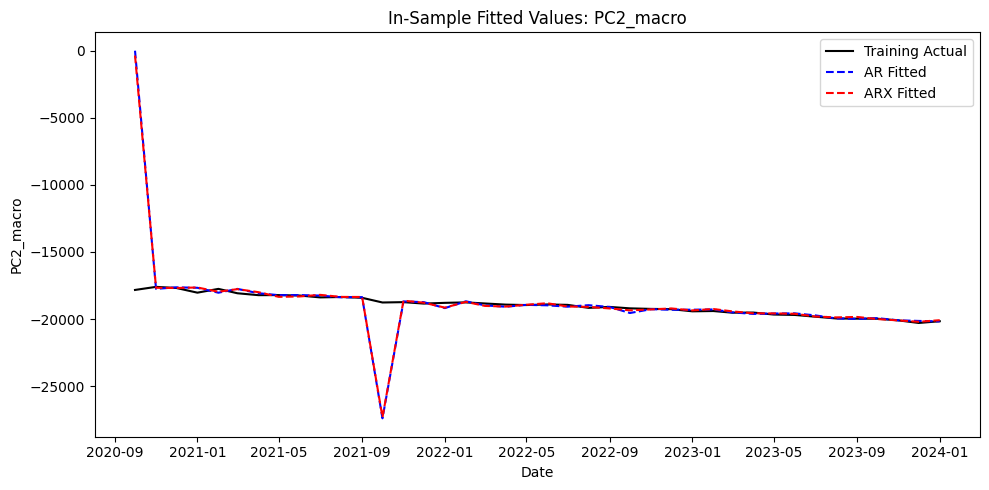

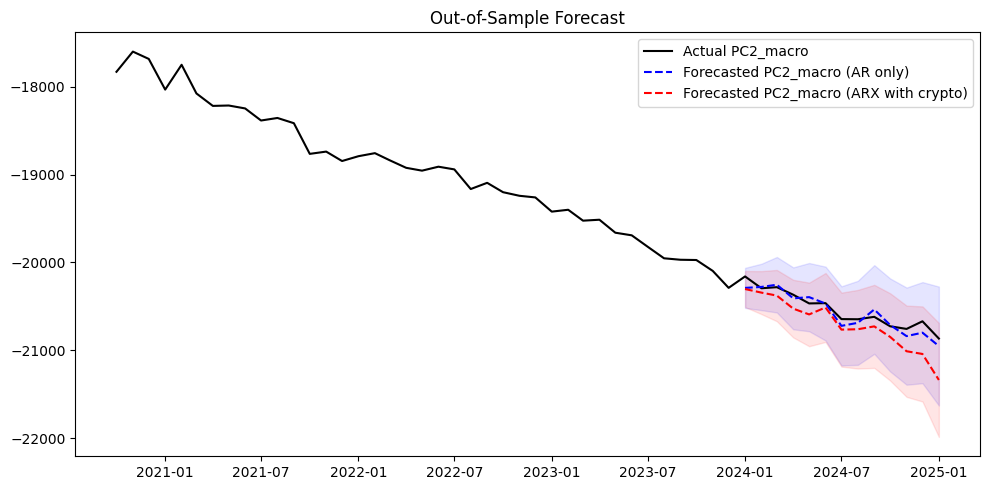

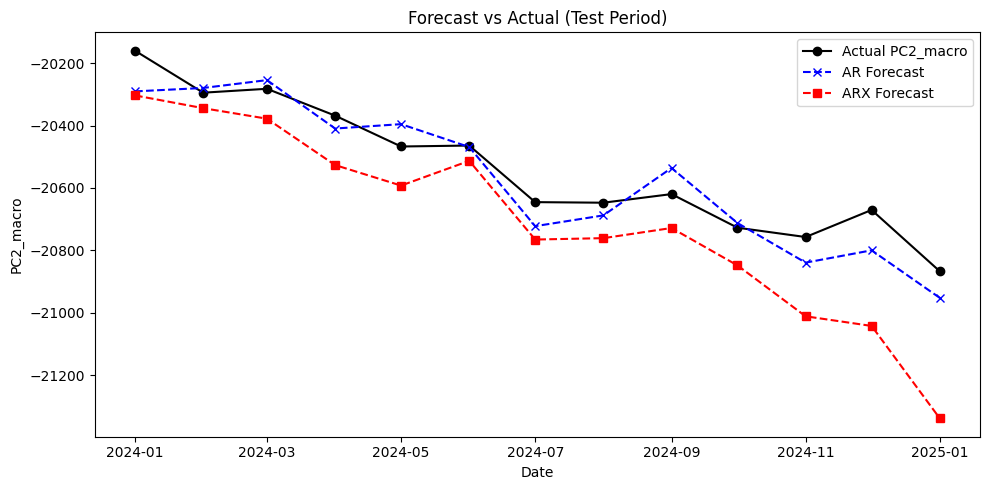

(              MAE        RMSE        R2  MAPE (%)    Order
 Model                                                     
 AR      61.891957   73.650878  0.871198  0.301153  (1,1,0)
 ARX    167.960905  206.603698 -0.013545  0.814497  (1,1,0),
 {'Breusch-Pagan p': np.float64(0.28576007514743856),
  'Shapiro p': np.float64(0.0035741596553558706),
  'Anderson stat': np.float64(1.1946514776643795),
  'Anderson crit': [(np.float64(15.0), np.float64(0.516)),
   (np.float64(10.0), np.float64(0.587)),
   (np.float64(5.0), np.float64(0.705)),
   (np.float64(2.5), np.float64(0.822)),
   (np.float64(1.0), np.float64(0.978))],
  'Mean resid': np.float64(-1.1532146524248394),
  'Durbin-Watson': np.float64(1.886542418758945)})

In [1987]:
run_model(df.copy(), 'PC2_macro', asset_list, plot = True)

In [1988]:
all_assumptions = []

for macro in ar_orders.keys():
    for asset in df.columns:
        if asset == macro:
            continue
        try:
            metrics, assumptions = run_model(df, macro, asset, plot=False)
            result_row = {
                "Macro": macro,
                "Asset": asset,
                "Breusch-Pagan p": assumptions["Breusch-Pagan p"],
                "Shapiro p": assumptions["Shapiro p"],
                "Anderson stat": assumptions["Anderson stat"],
                "Mean resid": assumptions["Mean resid"],
                "Durbin–Watson": assumptions["Durbin–Watson"]
            }

            # Optionally flatten Anderson critical values at 5% level
            for level, crit_val in assumptions["Anderson crit"]:
                if level == 5:
                    result_row["Anderson 5% crit"] = crit_val

            all_assumptions.append(result_row)

        except Exception as e:
            print(f"Failed for Macro: {macro}, Asset: {asset} — {e}")
assumptions_df = pd.DataFrame(all_assumptions)


Failed for Macro: LFPR, Asset: Bitcoin — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: Litecoin — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: XRP — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: Ethereum — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: Dogecoin — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: Cardano — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: Tether — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: USD Coin — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: CPI — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: r — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: M1 — can only concatenate list (not "str") to list
Failed for Macro: LFPR, Asset: IM — can only concatenate li

In [1989]:
assumptions_df

""


## Assumption Testing Results

In [1990]:
pd.set_option("display.max_rows", None)  # Show all rows
pd.set_option("display.max_columns", None)  # (optional) Show all columns
pd.set_option("display.width", None)  # Don't wrap columns
pd.set_option("display.max_colwidth", None)  # Don't truncate cell content
display(assumptions_df) 

""


## All Macro & Crypto Combination

In [1991]:
results_list = []
asset = 'Bitcoin'
for macro in macro_list:
        # Run model, plot=False to skip plotting in batch run
        metrics_df, assumptions_df = run_model(df.copy(), macro, asset, plot=False)
        
        # metrics_df is a DataFrame with index Model (AR, ARX) and columns MAE, RMSE, R2, MAPE, Order
        # Add macro and asset columns for clarity
        metrics_df['Macro'] = macro
        metrics_df['Asset'] = asset
        
        results_list.append(metrics_df.reset_index())
# Combine all results into one DataFrame
final_results = pd.concat(results_list, ignore_index=True)

# Rearrange columns to show Model, Macro, Asset, and errors only
final_results = final_results[['Model', 'Macro', 'Asset', 'MAE', 'RMSE', 'R2', 'MAPE (%)']]

# Format float columns for better readability
float_cols = ['MAE', 'RMSE', 'R2']
final_results[float_cols] = final_results[float_cols]

TypeError: can only concatenate list (not "str") to list

In [ ]:
final_results

### Combinations Where Adding Asset Data Improves the Model

In [ ]:
# Reshape for comparison
df_wide = final_results.pivot_table(
    index=['Macro', 'Asset'],
    columns='Model',
    values=['MAE', 'RMSE', 'R2', 'MAPE (%)']
)

df_wide.columns = ['_'.join(col).strip() for col in df_wide.columns.values]
df_wide.reset_index(inplace=True)

# Define better = lower RMSE, lower MAE, higher R²
df_wide['ARX_better_RMSE'] = df_wide['RMSE_ARX'] < df_wide['RMSE_AR']
df_wide['ARX_better_MAE'] = df_wide['MAE_ARX'] < df_wide['MAE_AR']
df_wide['ARX_better_MAPE'] = df_wide['MAPE (%)_ARX'] < df_wide['MAPE (%)_AR']
df_wide['ARX_better_R2']  = df_wide['R2_ARX']  > df_wide['R2_AR']

# Filter: only combinations where ARX is better by **all** metrics
better_all = df_wide[
    (df_wide['ARX_better_RMSE']) &
    (df_wide['ARX_better_MAE']) &
    (df_wide['ARX_better_MAPE']) &
    (df_wide['ARX_better_R2'])
]

# Display results
if not better_all.empty:
    print("Combinations where ARX (with asset) outperforms AR on all metrics (MAE, RMSE, MAPE, R²):")
    display(better_all[['Macro', 'Asset', 'MAE_AR', 'MAE_ARX', 'RMSE_AR', 'RMSE_ARX', 'MAPE (%)_AR', 'MAPE (%)_ARX', 'R2_AR', 'R2_ARX']])
else:
    print("No combination found where ARX beats AR across MAE, RMSE, and R².")


# Partial wins
print("\n Combinations where ARX has lower MAE:")
display(df_wide[df_wide['ARX_better_MAE']][['Macro', 'Asset', 'MAE_AR', 'MAE_ARX']])

print("\n Combinations where ARX has lower RMSE:")
display(df_wide[df_wide['ARX_better_RMSE']][['Macro', 'Asset', 'RMSE_AR', 'RMSE_ARX']])

print("\n Combinations where ARX has lower MAPE:")
display(df_wide[df_wide['ARX_better_MAPE']][['Macro', 'Asset', 'MAPE (%)_AR', 'MAPE (%)_ARX']])

print("\n Combinations where ARX has higher R²:")
display(df_wide[df_wide['ARX_better_R2']][['Macro', 'Asset', 'R2_AR', 'R2_ARX']])

## Testing Individual Combinations

In [ ]:
macro = 'LFPR'
asset = 'Bitcoin'
run_model(df.copy(), macro, asset, plot=True)

## Finding Optimal Crypto Lag

In [ ]:
def find_optimal_lag(df, macro, asset, max_lag=6, verbose=False):
    best_lag = None
    best_improvement = np.inf
    best_metrics = None

    results = []

    for lag in range(0, max_lag + 1):
        # Temporarily override lag

        try:
            metrics = run_model(df, macro, asset, lag, )
            ar = metrics.loc['AR']
            arx = metrics.loc['ARX']

            delta_mape = arx['MAPE (%)'] - ar['MAPE (%)']
            results.append({
                'Lag': lag,
                'ΔMAPE': delta_mape,
            })

            if delta_mape < best_improvement:
                best_lag = lag
                best_improvement = delta_mape
                best_metrics = metrics

            if verbose:
                print(f"Lag {lag}: ΔMAPE = {delta_mape:.2f}")

        except Exception as e:
            print(f"Lag {lag}: Failed with error: {e}")
            continue

    results_df = pd.DataFrame(results)
    return best_lag, best_improvement, results_df, best_metrics


In [ ]:
for macro in ar_orders.keys():
    best_lag, _, _, _ = find_optimal_lag(df, macro, asset="Bitcoin", max_lag=6)
    
    if best_lag is not None:
        ar_orders[macro]["Bitcoin_lag"] = best_lag
    else:
        ar_orders[macro]["Bitcoin_lag"] = np.nan 